In [1]:
#분석에 필요한 모듈 불러오기
%matplotlib inline
import random
import pandas as pd
import numpy as np
import os
import re

#데이터 시각화 모듈
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore')

#데이터 불러오기

In [2]:
#넷플릭스 데이터 불러오기
train = pd.read_csv("/content/drive/MyDrive/netflix-stock-prediction/train.csv")
test = pd.read_csv("/content/drive/MyDrive/netflix-stock-prediction/test.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


In [4]:
train.head()

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [5]:
test.head()

,Date,Open,High,Low,Volume
0,2019-10-21,273,280,269,12599200
1,2019-10-22,271,275,266,11802400
2,2019-10-23,268,274,267,7133500
3,2019-10-24,272,274,269,4827400
4,2019-10-25,271,278,270,4747800


In [6]:
len(test)

20

In [7]:
submission = pd.read_csv("/content/drive/MyDrive/netflix-stock-prediction/sample_submission.csv")

In [8]:
len(submission['Expected'])

20

#데이터 전처리

In [9]:
train = train[['Open',	'High',	'Low',	'Volume']]
test = test[['Open',	'High',	'Low',	'Volume']]

In [14]:
train_idx = [i for i in range(len(train)) if i % 5 != 4]
test_idx = [i for i in range(len(test))]
print(train_idx)
print(test_idx)

[0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 61, 62, 63, 65, 66, 67, 68, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 85, 86, 87, 88, 90, 91, 92, 93, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 108, 110, 111, 112, 113, 115, 116, 117, 118, 120, 121, 122, 123, 125, 126, 127, 128, 130, 131, 132, 133, 135, 136, 137, 138, 140, 141, 142, 143, 145, 146, 147, 148, 150, 151, 152, 153, 155, 156, 157, 158, 160, 161, 162, 163, 165, 166, 167, 168, 170, 171, 172, 173, 175, 176, 177, 178, 180, 181, 182, 183, 185, 186, 187, 188, 190, 191, 192, 193, 195, 196, 197, 198, 200, 201, 202, 203, 205, 206, 207, 208, 210, 211, 212, 213, 215, 216, 217, 218, 220, 221, 222, 223, 225, 226, 227, 228, 230, 231, 232, 233, 235, 236, 237, 238, 240, 241, 242, 243, 245, 246, 247, 248, 250, 251, 252, 253, 255, 256, 257, 258, 260, 261, 262, 263, 265, 266, 267, 268, 270, 27

In [17]:
train_idx = [i for i in range(len(train)) if i % 5 != 4]
test_idx = [i for i in range(len(test))]
x_train = train.iloc[train_idx, :-1]
y_train = train.iloc[train_idx, -1]
x_test = test.iloc[test_idx, :-1]
y_test = test.iloc[test_idx, -1]
print(y_train.value_counts())
print(y_test.value_counts())

11215000    2
4621500     2
13181000    1
22960000    1
12219900    1
           ..
4609300     1
4368900     1
4607600     1
3312400     1
23429900    1
Name: Volume, Length: 772, dtype: int64
12599200    1
11802400    1
6529000     1
9158900     1
5772800     1
3944300     1
4509000     1
5928500     1
3438300     1
4062400     1
5566200     1
5594300     1
5090000     1
9345600     1
4356200     1
6248400     1
4747800     1
4827400     1
7133500     1
6333800     1
Name: Volume, dtype: int64


#데이터 시각화

#폰트 지정

In [12]:
import platform

!apt install fonts-nanum

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Linux':
    plt.rc('font', family='Malgun Gothic')
else:
    print('Unknown system... sorry~~~~')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


#모델링

In [18]:
from sklearn.metrics import accuracy_score

# 1. Logistic regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
print("Logistic Regression:", accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))

Logistic Regression: 0.08527131782945736 0.0


In [19]:
# 2. Decision tree
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
print("Decision tree:", accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))

Decision tree: 0.9018087855297158 0.0


In [20]:
# 3. Support vector machine
from sklearn.svm import SVC
model = SVC()
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
print("Support vector machine:", accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))

Support vector machine: 0.003875968992248062 0.0


In [21]:
# 4. Gaussian naive bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test
                           )
print("Gaussian naive bayes:", accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))

Gaussian naive bayes: 0.8992248062015504 0.0


In [22]:
# 5. K nearest neighbor
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
print("K nearest neighbor:", accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))

K nearest neighbor: 0.15762273901808785 0.0


In [23]:
# 6. Random forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
print("Random forest:", accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))

Random forest: 0.9018087855297158 0.0


In [24]:
# 7. Gradient boosing
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
print("Gradient boosing:", accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))

Gradient boosing: 0.900516795865633 0.0


In [25]:
# 8. Neural network
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(max_iter=1000)
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
print("Neural network:", accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))
y_pred_train
y_pred_test

Neural network: 0.15891472868217055 0.0


array([ 5245100,  6324900,  6727200,  4621500,  9123600,  9123600,
        4621500, 13472500,  4621500,  4621500,  9827800,  4621500,
        4695700,  5245100,  3955700,  9827800,  6135800, 11215000,
        9827800, 18525800])

In [26]:
 len(y_pred_train)

774

#GridSearchCV

In [27]:
from sklearn.model_selection import GridSearchCV

###validation 셋 구축 X

In [28]:
params = {'n_estimators' : [100, 150, 200],
          'criterion' : ['gini', 'entropy']}

rf = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=2, return_train_score=True, verbose=2)

rf.fit(x_train, y_train)


Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END ...................criterion=gini, n_estimators=100; total time=   0.7s
[CV] END ...................criterion=gini, n_estimators=100; total time=   0.7s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.0s
[CV] END ...................criterion=gini, n_estimators=150; total time=   0.8s
[CV] END ...................criterion=gini, n_estimators=200; total time=   1.0s
[CV] END ...................criterion=gini, n_estimators=200; total time=   1.0s
[CV] END ................criterion=entropy, n_estimators=100; total time=   0.6s
[CV] END ................criterion=entropy, n_estimators=100; total time=   0.6s
[CV] END ................criterion=entropy, n_estimators=150; total time=   1.0s
[CV] END ................criterion=entropy, n_estimators=150; total time=   1.0s
[CV] END ................criterion=entropy, n_estimators=200; total time=   1.3s
[CV] END ................criterion=entropy, n_est

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [100, 150, 200]},
             return_train_score=True, verbose=2)

In [ ]:
rf.best_score_

In [ ]:
rf.best_params_

#모델 앙상블

##1) GridSearchCV로 모델 학습

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [32]:
models = []

rfc = RandomForestClassifier()

models.append(rfc)

gbc = GradientBoostingClassifier()

models.append(gbc)

etc = ExtraTreesClassifier()

models.append(etc)

In [33]:
best_models = {}
params = [{}, {}, {}]

for i, model in enumerate(models):
  model = GridSearchCV(model, param_grid=params[i], cv=2, return_train_score=True, verbose=2)

  model.fit(x_train,y_train)

  best_models[i] = model.best_estimator_

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.5s
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END .................................................... total time= 2.4min
[CV] END .................................................... total time= 2.4min
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.4s


In [35]:
print("최적의 하이퍼파라미터:", model.best_params_)
print("최고 예측 정확도: {:.2f}".format(model.best_score_))

최적의 하이퍼파라미터: {}
최고 예측 정확도: 0.00
최적의 하이퍼파라미터: {}
최고 예측 정확도: 0.00


#모델 예측(시험 데이터셋)

In [36]:
submission['Expected'] = y_pred_test
submission.to_csv('sample_submission1.csv', index=False)
submission.head()

,Id,Expected
0,1,5245100
1,2,6324900
2,3,6727200
3,4,4621500
4,5,9123600


In [46]:
prediction = pd.DataFrame({'y_pred_train':y_pred_train[-20:], 'y_pred_test':y_pred_test})
prediction

,y_pred_train,y_pred_test
0,4621500,5245100
1,8312400,6324900
2,11215000,6727200
3,23429900,4621500
4,9710400,9123600
5,16338200,9123600
6,11215000,4621500
7,11215000,13472500
8,6727200,4621500
9,5245100,4621500


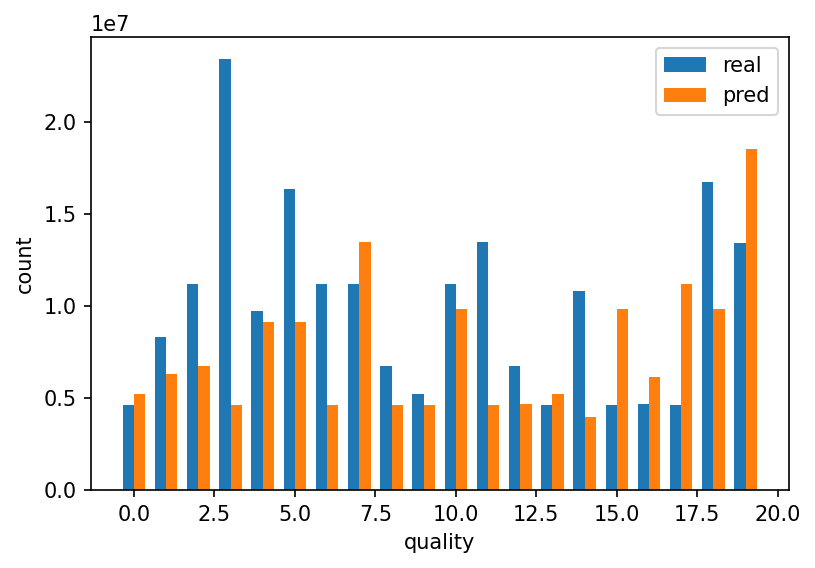

In [51]:
x = prediction.index
y_train_count = prediction['y_pred_train']
y_test_count = prediction['y_pred_test']

width = 0.35

plt.figure(dpi=150)

plt.xlabel('quality')
plt.ylabel('count')

p1 = plt.bar([idx-width/2 for idx in x], y_train_count, width, label='real')
p2 = plt.bar([idx+width/2 for idx in x], y_test_count, width, label='pred')

plt.legend()
plt.show()

